## Signature Inversion

This notebook follows Section 3.6 of [Deep Signature Transforms](https://arxiv.org/pdf/1905.08494.pdf). PyTorch code can be found at [this](https://github.com/patrick-kidger/Deep-Signature-Transforms/blob/master/src/example_signature_inversion.ipynb)

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np
import optax
from signax import signature


jax.config.update("jax_platform_name", "cpu")

In [2]:
seed = 1234
key = jrandom.PRNGKey(seed)
signature_depth = 12
learning_rate = 2 * 1e-3
num_training_iters = 5000

### Preprocessing data
Here we consider number 0

In [3]:
# number zero (PenDigit)
path = [29, 97, 0, 57, 22, 10, 68, 0, 100, 40, 83, 90, 37, 100, 12, 57]
path = np.array(path, dtype=float).reshape(-1, 2)
# rescale into range (-1,1)
path = -1.0 + 2 * (path - np.min(path)) / (np.max(path) - np.min(path))
path = jnp.array(path)

Let's visualize the data

(-1.1, 1.1, -1.1, 1.1)

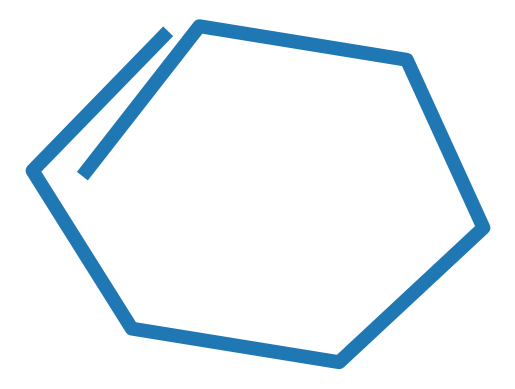

In [4]:
plt.plot(*path.T, label="Original path", linewidth=10, linestyle="-")
plt.axis("off")

Compute signature of the given data

In [5]:
sig = signature(path, depth=signature_depth)

### Model

This model is quite simple: set of parameters (in `eqx.nn.Linear`) represents the path.

The model outputs the signature of the learnable parameters.

In [6]:
class InvertSignature(eqx.Module):
    path_length: int
    signature_depth: int

    # path represented as weight of linear layer
    # can instead use `jnp.ndarray`
    path: eqx.nn.Linear

    def __init__(self, path_length, signature_depth, *, key) -> None:
        self.path_length = path_length
        self.signature_depth = signature_depth

        self.path = eqx.nn.Linear(
            in_features=1,
            out_features=2 * path_length,
            use_bias=False,
            key=key,
        )

    def generate_path(self, x):
        x = self.path(x)
        return jnp.reshape(x, (self.path_length, 2))

    def __call__(self, x):
        x = self.generate_path(x)
        return signature(path=x, depth=signature_depth)

Model instantiation

In [7]:
model = InvertSignature(
    path_length=path.shape[0], signature_depth=signature_depth, key=key
)

Create optimizer

In [8]:
optim = optax.adam(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

A normalization term to compute the loss. The idea here is to penalize more higher order of signatures

In [9]:
normalization = [
    np.floor(np.log(i + 1) / np.log(2))
    for i in range(1, 2 ** (signature_depth + 1) - 1)
]
normalization = jnp.array(normalization)

In fact, the input of the model is fixed

In [10]:
x = jnp.ones((1, 1))
y = sig

Compute loss in Equinox style

In [11]:
@eqx.filter_value_and_grad
def compute_loss(model):
    pred_sig = model(x)
    diff = y - pred_sig
    diff = diff * normalization
    return jnp.log(jnp.mean(diff**2))


@eqx.filter_jit
def make_step(model, opt_state):
    loss, grads = compute_loss(model)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

### Training step

In [12]:
for i in range(num_training_iters):
    loss, model, opt_state = make_step(model, opt_state)
    loss = loss.item()
    if i % 500 == 0:
        print(f"Iter={i} \t loss={loss:.4f}")

Iter=0 	 loss=2.1267
Iter=500 	 loss=-7.2773
Iter=1000 	 loss=-7.7294
Iter=1500 	 loss=-8.0810
Iter=2000 	 loss=-8.3676
Iter=2500 	 loss=-8.6448
Iter=3000 	 loss=-8.9190
Iter=3500 	 loss=-9.2010
Iter=4000 	 loss=-9.4967
Iter=4500 	 loss=-9.8067


### Helper function to refine path
The following two functions taken from [this file](https://github.com/patrick-kidger/Deep-Signature-Transforms/blob/master/src/signature_inversion.py)

In [13]:
def _get_tree_reduced_steps(X, order=4, steps=4, tol=0.1):
    if len(X) < steps:
        return X

    dim = X.shape[1]

    # slide over a window size = `steps``
    for i in range(steps - 1, len(X)):
        # no redudancy in path -> compute its signature
        new_path = X[i - steps + 1 : i + 1]  # noqa: E203
        new_path_sig = signature(new_path, order)

        # reduce the path with the first and the last
        new_path2 = jnp.r_[
            X[i - steps + 1].reshape(-1, dim),
            X[i].reshape(-1, dim),
        ]
        new_path2_sig = signature(new_path2, order)

        # compute the difference between two signatures
        norm = jnp.linalg.norm(new_path_sig - new_path2_sig)
        if norm < tol:
            # if it is reducible, the perform the same procedure on the
            # next sub path
            return _get_tree_reduced_steps(np.r_[X[: i - steps + 2], X[i:]])

    return X


def get_tree_reduced(X, order=4, tol=0.1):
    """Removes tree-like pieces of the path."""
    X = jnp.r_[X, [X[-1]]]

    for step in range(3, len(X) + 1):
        X = _get_tree_reduced_steps(X, order, step, tol)

    if (X[-1] == X[-2]).all():
        return X[:-1]

    return X

### Plot result

(-1.111672592163086, 1.113952350616455, -1.1, 1.1)

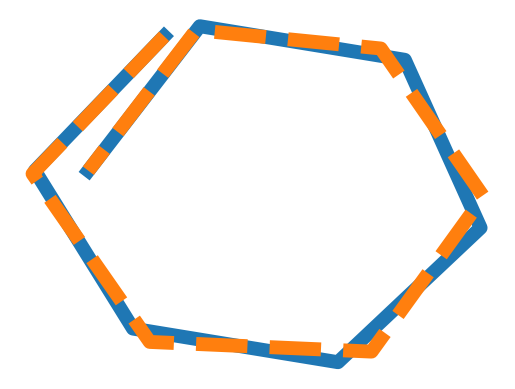

In [14]:
generated_path = model.generate_path(x)
generated_path += path[0] - generated_path[0]
generated_path = get_tree_reduced(generated_path, tol=1e-2)

plt.plot(
    *path.T,
    label="Original path",
    linewidth=10,
    linestyle="-",
)
plt.plot(
    *generated_path.T,
    label="Generated path",
    linewidth=10,
    linestyle="--",
)
plt.axis("off")